In [1]:
import graphviz
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm, multivariate_normal
import sklearn
from sklearn import tree
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Obtain Data

In [2]:
df_churn = pd.read_csv(r"C:\Users\Nick\Desktop\bigml_59c28831336c6604c800002a.csv")

In [3]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

#### Initial Observations--Phone number can be dropped since it doesn't provide meaningful data (cannot recognize pattern that wouldn't already be captured by area code...Int plan and VM plan are 'binary' so need to be changed

#### Dropped Phone Number

In [4]:
df_churn = df_churn.drop(['phone number'], axis=1)

In [5]:
df_churn.state.nunique()

51

#### Too many states, load in regions to limit number of Cat variables.

In [6]:
df_regions = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')

In [7]:
df_regions.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


#### Merge regions with churn data.

In [8]:
df_churn = df_churn.merge(df_regions, left_on = 'state', right_on = 'State Code')

#### Look at count of divisions, making sure somewhat evenly balanced counts.

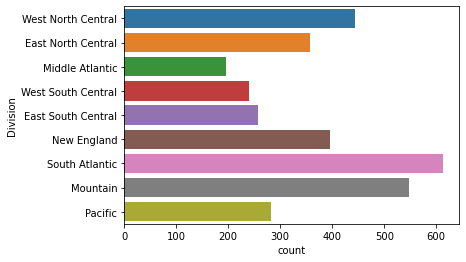

In [9]:
sns.countplot(y = 'Division', data = df_churn)

#### Drop now unnecessary columns. (State, State Code, Region)

In [10]:
df_churn.drop(columns = ['State','State Code','Region', 'state'], axis =1, inplace=True)

In [11]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   international plan      3333 non-null   object 
 3   voice mail plan         3333 non-null   object 
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

#### Convert intl plan and vm plan to 0's and 1's (binary variables)

In [12]:
df_churn['international plan'] = df_churn['international plan'].map(lambda x: 1 if x == 'yes' else 0)

In [13]:
df_churn['international plan'].value_counts()

0    3010
1     323
Name: international plan, dtype: int64

In [14]:
df_churn['voice mail plan'] = df_churn['voice mail plan'].map(lambda x: 1 if x == 'yes' else 0)

In [15]:
df_churn['voice mail plan'].value_counts()

0    2411
1     922
Name: voice mail plan, dtype: int64

In [16]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   international plan      3333 non-null   int64  
 3   voice mail plan         3333 non-null   int64  
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

#### Check for duplicates

In [17]:
df_churn.index.duplicated().sum()

0

#### Check for missing values

In [18]:
df_churn.isna().sum()

account length            0
area code                 0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
Division                  0
dtype: int64

# Explore

#### Checking balance of data. (In this case, an imbalance...)

In [19]:
df_churn['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [20]:
Percent_churn = 483/(2850+483)
print(Percent_churn)

0.14491449144914492


#### Plotting number of observations staying vs leaving

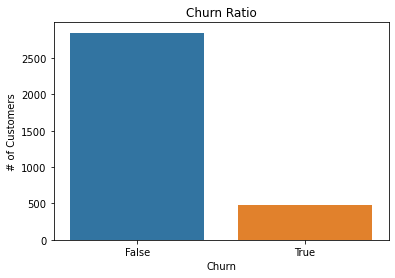

In [21]:
# plot staying vs leaving customer
# churn means leaving if TRUE
sns.countplot(x = 'churn', data = df_churn)
plt.title('Churn Ratio')
plt.xlabel('Churn')
plt.ylabel('# of Customers')
plt.savefig("Ratio of Churn")

#### Initial feature correlation...looking for any obvious correlations between churn and features

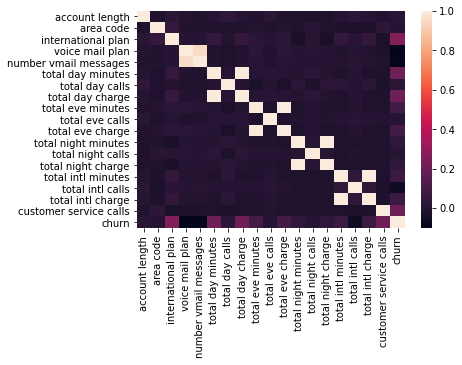

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
account length,1.000000,-0.012463,0.024735,0.002918,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
area code,-0.012463,1.000000,0.048551,-0.000747,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572,0.006174
international plan,0.024735,0.048551,1.000000,0.006006,0.008745,0.049396,0.003755,0.049398,0.019100,0.006114,0.019106,-0.028905,0.012451,-0.028913,0.045871,0.017366,0.045780,-0.024522,0.259852
voice mail plan,0.002918,-0.000747,0.006006,1.000000,0.956927,-0.001684,-0.011086,-0.001686,0.021545,-0.006444,0.021559,0.006079,0.015553,0.006064,-0.001318,0.007618,-0.001276,-0.017824,-0.102148
number vmail messages,-0.004628,-0.001994,0.008745,0.956927,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
total day minutes,0.006216,-0.008264,0.049396,-0.001684,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151
total day calls,0.038470,-0.009646,0.003755,-0.011086,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
total day charge,0.006214,-0.008264,0.049398,-0.001686,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
total eve minutes,-0.006757,0.003580,0.019100,0.021545,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796
total eve calls,0.019260,-0.011886,0.006114,-0.006444,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233


In [22]:
sns.heatmap(df_churn.corr())
plt.show()

df_churn.corr()

**We notice intl plan, total day plan, total day charge, customer service calls all seem to have good correlation with the churn.  The divisions seem to have little impact on on being an indicator for probability of churn.**

In [23]:
feats = df_churn[['account length', 
                  'area code', 
                  'number vmail messages', 
                  'total day minutes', 
                  'total day calls', 
                  'total day charge', 
                  'total eve minutes', 
                  'churn']]

In [24]:
feats.head()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,churn
0,128,415,25,265.1,110,45.07,197.4,False
1,70,408,0,232.1,122,39.46,292.3,False
2,92,408,0,62.6,111,10.64,180.6,True
3,137,408,0,205.9,88,35.00,209.3,False
4,132,415,0,83.4,110,14.18,232.2,False


**Area code doesn't seem to have many unique values...**

In [25]:
feats['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

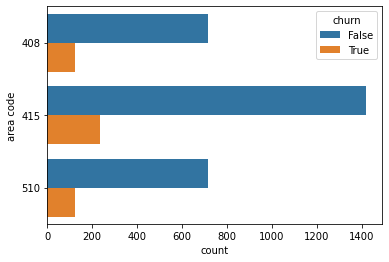

In [26]:
sns.countplot(y = df_churn['area code'], data = feats, hue = 'churn')

#### Investigate elements inside features

In [27]:
### This code shows number of distinct values inside each column (and lists them if possible)

for column in df_churn:
    unique_vals = np.unique(df_churn[column])
    nr_values = len(unique_vals)
    if nr_values < 25:
        print('The number of values for feature {} :{} -- {}'
              .format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'
              .format(column, nr_values))

The number of values for feature account length :212
The number of values for feature area code :3 -- [408 415 510]
The number of values for feature international plan :2 -- [0 1]
The number of values for feature voice mail plan :2 -- [0 1]
The number of values for feature number vmail messages :46
The number of values for feature total day minutes :1667
The number of values for feature total day calls :119
The number of values for feature total day charge :1667
The number of values for feature total eve minutes :1611
The number of values for feature total eve calls :123
The number of values for feature total eve charge :1440
The number of values for feature total night minutes :1591
The number of values for feature total night calls :120
The number of values for feature total night charge :933
The number of values for feature total intl minutes :162
The number of values for feature total intl calls :21 -- [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
The number of v

#### Create pairplot to show potential relationship between variables in data.

C:\Users\Nick\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


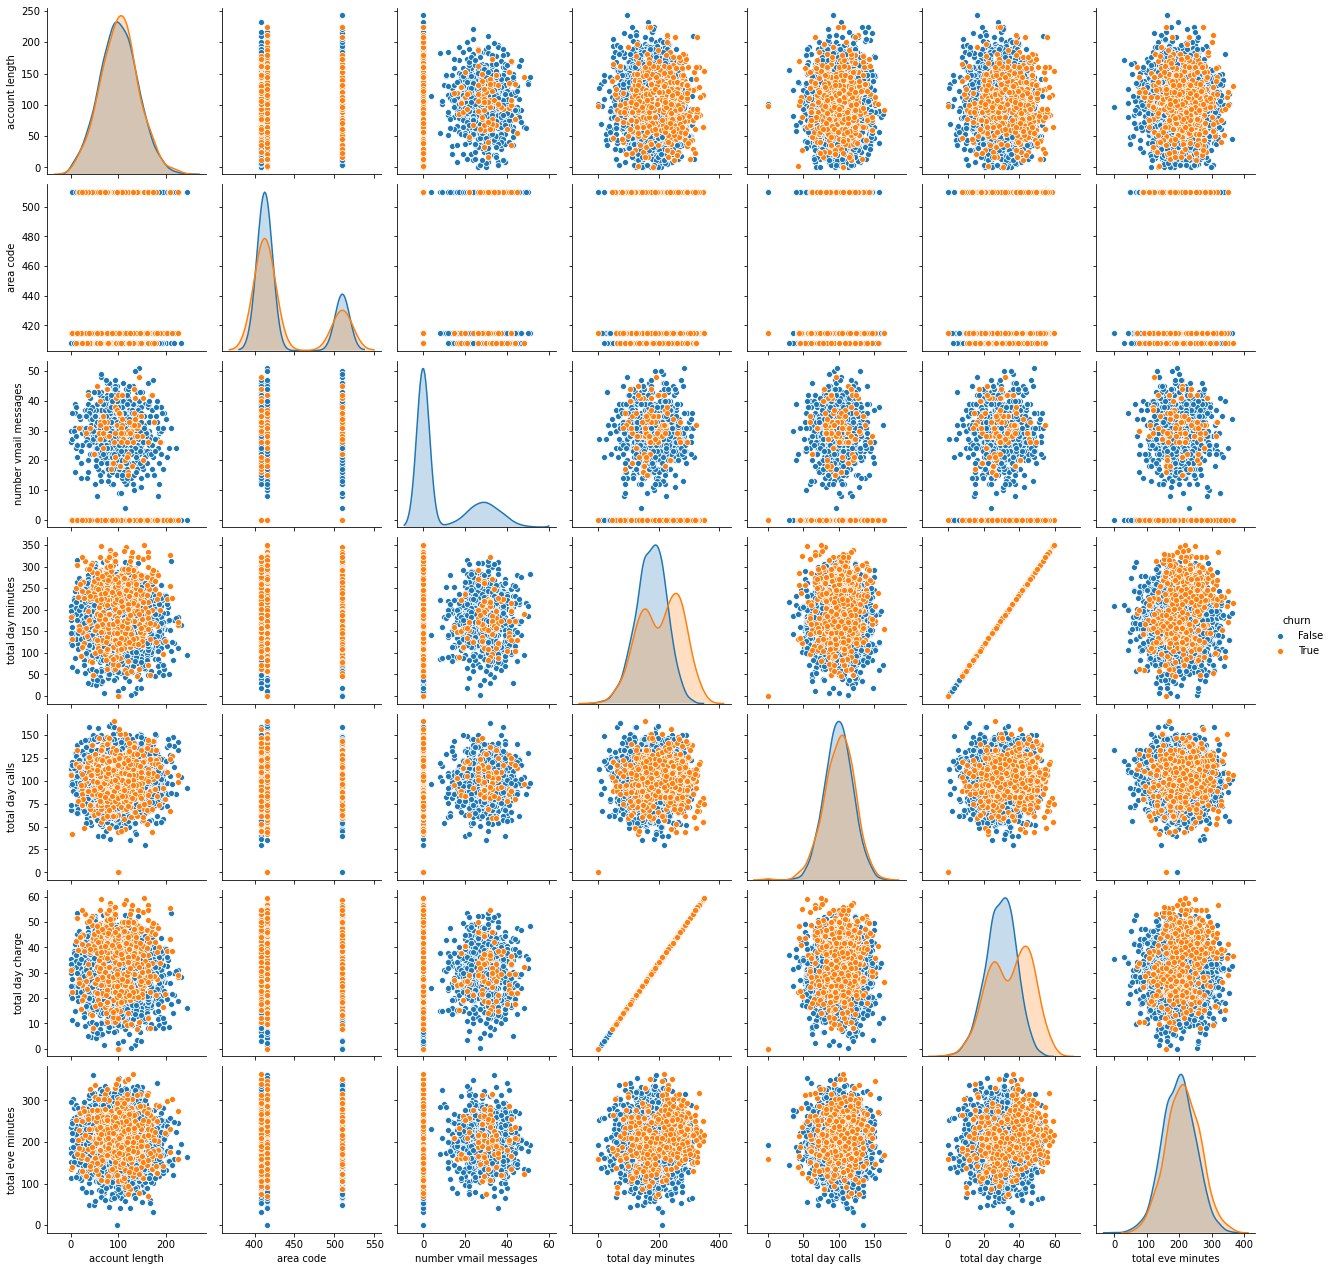

In [28]:
g = sns.pairplot(feats, hue = 'churn')
plt.savefig('Features Pairplot')

#### Look at "strongest" features to see if anything sticks out.

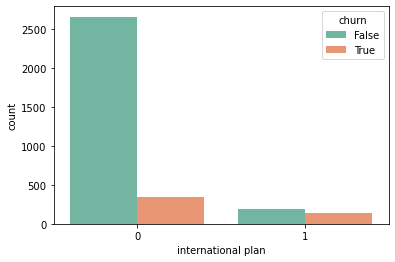

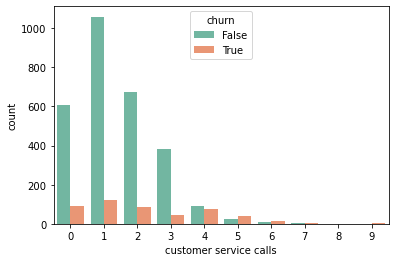

In [29]:
feats_small = ['international plan', 'customer service calls']

for f in feats_small:
    plt.figure()
    ax = sns.countplot(x=f, data=df_churn, hue = 'churn', palette = 'Set2')

High percent of those with intl' plan are churn...as # of service calls increases, so does percent of people churning...(seems to make sense since those were our two most strongly correlated variables.

##### Create new df (drop area code, TTS, then scale float columns)

In [30]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   international plan      3333 non-null   int64  
 3   voice mail plan         3333 non-null   int64  
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

In [31]:
df_churn = df_churn.drop(['area code'], axis=1)

In [32]:
df_churn.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,Division
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,West North Central
1,70,0,0,0,232.1,122,39.46,292.3,112,24.85,201.2,112,9.05,0.0,0,0.00,3,False,West North Central
2,92,1,0,0,62.6,111,10.64,180.6,126,15.35,221.7,80,9.98,10.4,2,2.81,1,True,West North Central
3,137,0,0,0,205.9,88,35.00,209.3,86,17.79,289.9,84,13.05,14.5,4,3.92,2,False,West North Central
4,132,0,0,0,83.4,110,14.18,232.2,137,19.74,146.7,114,6.60,7.6,5,2.05,1,False,West North Central


## Train-Test-Split

In [37]:
### Splitting raw data ONLY ONCE

X = df_churn.drop(columns=['churn'], axis=1) # features
y = df_churn['churn']  # target vector
print(f'X shape:  {X.shape}')
print(f'y shape:  {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, stratify=y, random_state=87)

print(f'X_train shape:  {X_train.shape}')
print(f'y_train shape:  {y_train.shape}')

print(f'X_test shape:  {X_test.shape}')
print(f'y_test shape:  {y_test.shape}')

X shape:  (3333, 18)
y shape:  (3333,)
X_train shape:  (2666, 18)
y_train shape:  (2666,)
X_test shape:  (667, 18)
y_test shape:  (667,)


#### One-Hot-Encode

In [73]:
ohe_division = X_train.iloc[:,:19]

In [75]:
X_train = ohe_division.apply(LabelEncoder().fit_transform)

#### Scale Columns

In [79]:
scale_vars = ['account length', 
              'number vmail messages', 
              'total day minutes', 
              'total day calls', 
              'total day charge', 
              'total eve minutes',  
              'total eve calls', 
              'total eve charge',
              'total night minutes',
              'total night calls', 
              'total night charge',
              'total intl minutes',
              'total intl calls',
              'total intl charge', 
              'customer service calls'
             ]
scaler = MinMaxScaler()
X_train[scale_vars] = scaler.fit_transform(X_train[scale_vars])
X_train.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,Division
206,0.604878,0,0,0.0,0.837910,0.427350,0.837910,0.586254,0.436975,0.580030,0.745455,0.713043,0.709898,0.745223,0.315789,0.745223,0.000000,2
819,0.180488,0,0,0.0,0.445412,0.632479,0.445412,0.158763,0.697479,0.167683,0.795804,0.600000,0.756542,0.528662,0.157895,0.528662,0.444444,7
1371,0.560976,0,0,0.0,0.547220,0.162393,0.547220,0.586942,0.201681,0.580793,0.617483,0.469565,0.594994,0.382166,0.368421,0.382166,0.444444,3
1621,0.990244,0,0,0.0,0.515070,0.863248,0.515070,0.751890,0.193277,0.741616,0.604196,0.495652,0.584755,0.420382,0.105263,0.420382,0.111111,3
730,0.326829,0,0,0.0,0.251842,0.470085,0.251842,0.691409,0.420168,0.682165,0.834266,0.582609,0.789534,0.343949,0.315789,0.343949,0.333333,4


In [87]:
ohe_division_X_test = X_test.iloc[:,:19]

In [88]:
X_test = ohe_division_X_test.apply(LabelEncoder().fit_transform)

In [97]:
scale_vars = ['account length', 
              'number vmail messages', 
              'total day minutes', 
              'total day calls', 
              'total day charge', 
              'total eve minutes',  
              'total eve calls', 
              'total eve charge',
              'total night minutes',
              'total night calls', 
              'total night charge',
              'total intl minutes',
              'total intl calls',
              'total intl charge', 
              'customer service calls'
             ]
scaler = MinMaxScaler()
X_test[scale_vars] = scaler.fit_transform(X_test[scale_vars])
X_test.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,Division
769,0.809249,1,0,0.000000,0.387211,0.447917,0.387211,0.972727,0.587629,0.971591,0.025926,0.635417,0.031603,0.550388,0.166667,0.550388,0.000000,4
2226,0.716763,0,1,0.277778,0.726465,0.520833,0.726465,0.776364,0.835052,0.774621,0.235185,0.843750,0.250564,0.829457,0.666667,0.829457,0.000000,0
878,0.196532,0,0,0.000000,0.833037,0.416667,0.833037,0.687273,0.938144,0.689394,0.155556,0.666667,0.176072,0.372093,0.111111,0.372093,0.142857,3
3018,0.242775,0,1,0.638889,0.589698,0.562500,0.589698,0.756364,0.288660,0.755682,0.670370,0.416667,0.668172,0.542636,0.611111,0.542636,0.285714,4
1378,0.722543,0,0,0.000000,0.284192,0.208333,0.284192,0.623636,0.474227,0.626894,0.796296,0.177083,0.794582,0.658915,0.222222,0.658915,0.428571,3


#### Problem Statement/Business Value

**--- Looking to establish model to efficiently identify high-potential churn customers to improve customer retention.  Focused on customers who are predicted to churn, and who actually churned to make sure we're allocating resources efficiently and effectively when determining who is most likely to leave and based on which empirical features/indicators.  By identifying customers most likely to churn, we can improve on the things that are causing them to churn by informing SyriaTel BEFORE they churn.  This can lead to a large increase in profit for the company.**

# Model

### Baseline Model

^^ Create using most of the original features

In [98]:
dec_tree = DecisionTreeClassifier(criterion='entropy', 
                                  max_depth=6, 
                                  random_state=1)
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

#### Plot Decision Tree

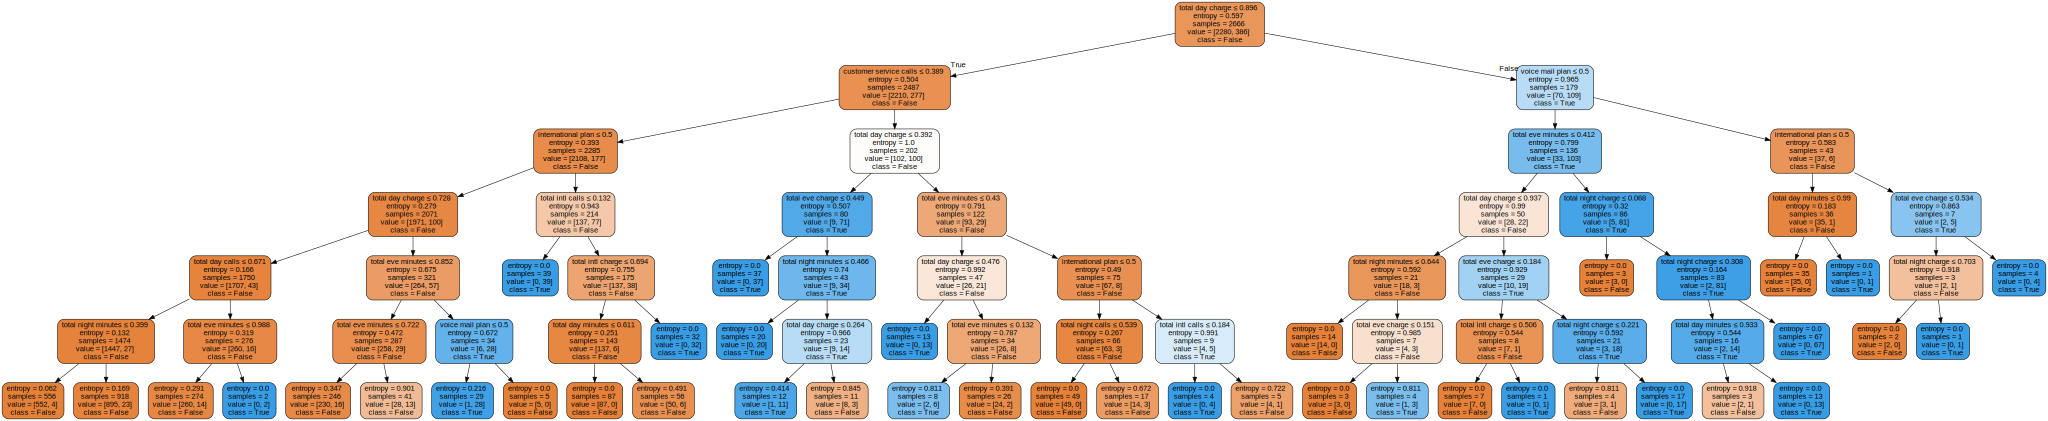

In [99]:
dot_data = tree.export_graphviz(dec_tree, out_file=None,
                               feature_names=df_churn
                                .drop('churn', axis=1).columns,
                               class_names=y_test.unique().astype(str),
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Feature Importance

In [100]:
### Calculating feature importance--score that is assigned to input features based on how useful they are at predicting target variable

for i, column in enumerate(df_churn.drop('churn', axis=1)):
    print('Importance of feature {}:, {:.3f}'
          .format(column, dec_tree.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': 
                       [dec_tree.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

Importance of feature account length:, 0.000
Importance of feature international plan:, 0.127
Importance of feature voice mail plan:, 0.050
Importance of feature number vmail messages:, 0.000
Importance of feature total day minutes:, 0.019
Importance of feature total day calls:, 0.008
Importance of feature total day charge:, 0.304
Importance of feature total eve minutes:, 0.121
Importance of feature total eve calls:, 0.000
Importance of feature total eve charge:, 0.023
Importance of feature total night minutes:, 0.018
Importance of feature total night calls:, 0.006
Importance of feature total night charge:, 0.028
Importance of feature total intl minutes:, 0.000
Importance of feature total intl calls:, 0.067
Importance of feature total intl charge:, 0.091
Importance of feature customer service calls:, 0.138
Importance of feature Division:, 0.000


#### CM and CR

In [101]:
print(confusion_matrix(y_test, dec_tree.predict(X_test)))
print(classification_report(y_test, dec_tree.predict(X_test)))

[[526  44]
 [ 21  76]]
              precision    recall  f1-score   support

       False       0.96      0.92      0.94       570
        True       0.63      0.78      0.70        97

    accuracy                           0.90       667
   macro avg       0.80      0.85      0.82       667
weighted avg       0.91      0.90      0.91       667



#### Random Forest 

In [102]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)

#### CM and CR

In [103]:
print(confusion_matrix(y_test, rf.predict(X_test)))
print(classification_report(y_test, rf.predict(X_test)))

[[531  39]
 [ 27  70]]
              precision    recall  f1-score   support

       False       0.95      0.93      0.94       570
        True       0.64      0.72      0.68        97

    accuracy                           0.90       667
   macro avg       0.80      0.83      0.81       667
weighted avg       0.91      0.90      0.90       667



#### Tuning Random Forest using GridSearchCV

In [104]:
rf = RandomForestClassifier(random_state=101)

params = {
    'max_features': [1, 'sqrt', 'log2'],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'criterion': ['entropy', 'gini']
}

grid = GridSearchCV(estimator= rf, param_grid=params, verbose=1)

In [105]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=101),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 'sqrt', 'log2']},
             verbose=1)

In [106]:
grid.best_params_

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt'}

In [107]:
rf_best = grid.best_estimator_

#### CM and CR

In [108]:
print(confusion_matrix(y_test, rf_best.predict(X_test)))
print(classification_report(y_test, rf_best.predict(X_test)))

[[525  45]
 [ 23  74]]
              precision    recall  f1-score   support

       False       0.96      0.92      0.94       570
        True       0.62      0.76      0.69        97

    accuracy                           0.90       667
   macro avg       0.79      0.84      0.81       667
weighted avg       0.91      0.90      0.90       667



##### Observations...Decision tree has 78% recall while random forest has 76%.

### Model 2

#### Refine Features

In [109]:
columns_to_drop = [
    'account length', 
    'voice mail plan',
    'total day calls', 
    'total intl minutes'
]

X_train_1 = X_train.drop(columns=columns_to_drop)
X_test_1 = X_test.drop(columns=columns_to_drop)

# Sanity check
print(f'X_train shape:  {X_train_1.shape}')
print(f'y_train shape:  {y_train.shape}')

X_train shape:  (2666, 14)
y_train shape:  (2666,)


#### Plot Decision Tree

In [110]:
dec_tree = DecisionTreeClassifier(
    criterion='entropy', max_depth=6, random_state=1)

dec_tree.fit(X_train_1, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

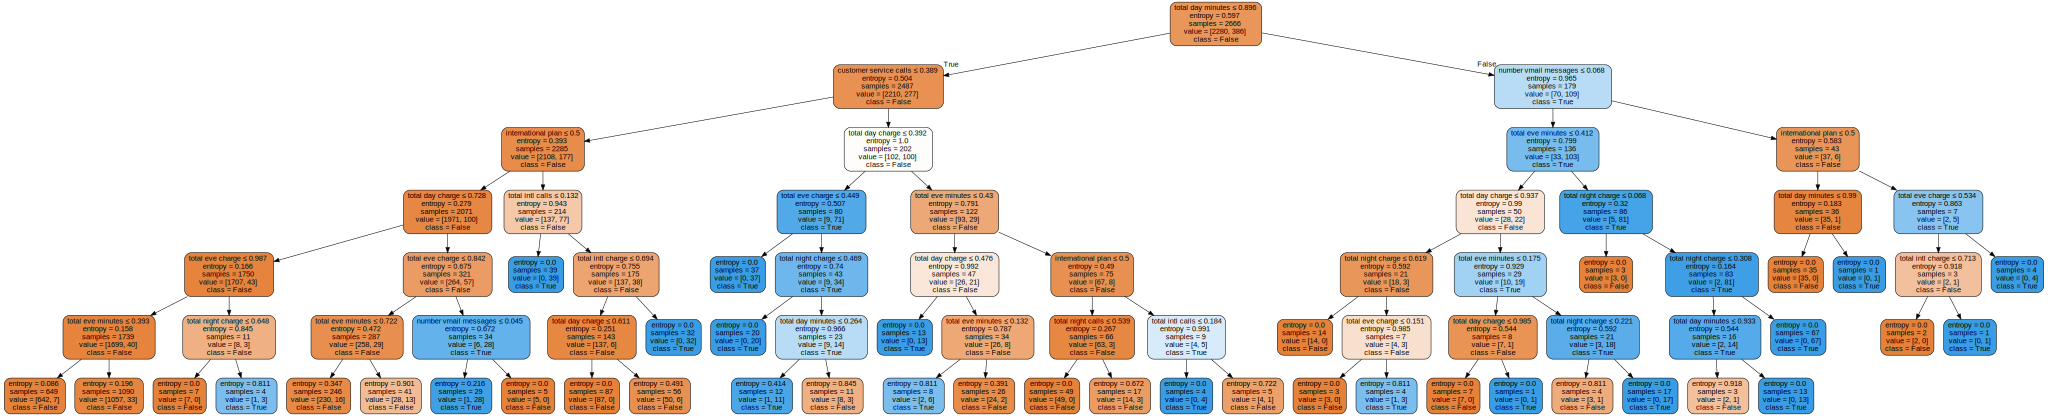

In [111]:
dot_data = tree.export_graphviz(
    dec_tree, out_file=None,
    feature_names=X_train_1.columns,
    class_names=y_test.unique().astype(str),
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Feature Importance

In [112]:
### Calculating feature importance again-

for i, column in enumerate(X_train_1):
    print('Importance of feature {}:, {:.3f}'
          .format(column, dec_tree.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': 
                       [dec_tree.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

Importance of feature international plan:, 0.128
Importance of feature number vmail messages:, 0.050
Importance of feature total day minutes:, 0.167
Importance of feature total day charge:, 0.161
Importance of feature total eve minutes:, 0.076
Importance of feature total eve calls:, 0.000
Importance of feature total eve charge:, 0.073
Importance of feature total night minutes:, 0.000
Importance of feature total night calls:, 0.006
Importance of feature total night charge:, 0.044
Importance of feature total intl calls:, 0.068
Importance of feature total intl charge:, 0.089
Importance of feature customer service calls:, 0.138
Importance of feature Division:, 0.000


##### Division have very little importance, drop them after random forest model.

#### CM and CR

In [113]:
print(confusion_matrix(y_test, dec_tree.predict(X_test_1)))
print(classification_report(y_test, dec_tree.predict(X_test_1)))

[[525  45]
 [ 21  76]]
              precision    recall  f1-score   support

       False       0.96      0.92      0.94       570
        True       0.63      0.78      0.70        97

    accuracy                           0.90       667
   macro avg       0.79      0.85      0.82       667
weighted avg       0.91      0.90      0.91       667



#### Random Forest (Using GridSCV)

In [114]:
rf = RandomForestClassifier(random_state=101)

params = {
    'max_features': [1, 'sqrt', 'log2'],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'criterion': ['entropy', 'gini']
}

grid = GridSearchCV(estimator= rf, param_grid=params, verbose=1)

In [115]:
grid.fit(X_train_1, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=101),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 'sqrt', 'log2']},
             verbose=1)

In [116]:
rf_best = grid.best_estimator_

#### CM and CR

In [117]:
print(confusion_matrix(y_test, rf_best.predict(X_test_1)))
print(classification_report(y_test, rf_best.predict(X_test_1)))

[[527  43]
 [ 23  74]]
              precision    recall  f1-score   support

       False       0.96      0.92      0.94       570
        True       0.63      0.76      0.69        97

    accuracy                           0.90       667
   macro avg       0.80      0.84      0.82       667
weighted avg       0.91      0.90      0.90       667



##### Observations...Decision tree has 78% recall while random forest has 76%.

### Model 3

#### Refine Features

##### Divisions look to have very little importance, drop them with anything else that has low FI.

In [119]:
X_train

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,Division
206,0.604878,0,0,0.0,0.837910,0.427350,0.837910,0.586254,0.436975,0.580030,0.745455,0.713043,0.709898,0.745223,0.315789,0.745223,0.000000,2
819,0.180488,0,0,0.0,0.445412,0.632479,0.445412,0.158763,0.697479,0.167683,0.795804,0.600000,0.756542,0.528662,0.157895,0.528662,0.444444,7
1371,0.560976,0,0,0.0,0.547220,0.162393,0.547220,0.586942,0.201681,0.580793,0.617483,0.469565,0.594994,0.382166,0.368421,0.382166,0.444444,3
1621,0.990244,0,0,0.0,0.515070,0.863248,0.515070,0.751890,0.193277,0.741616,0.604196,0.495652,0.584755,0.420382,0.105263,0.420382,0.111111,3
730,0.326829,0,0,0.0,0.251842,0.470085,0.251842,0.691409,0.420168,0.682165,0.834266,0.582609,0.789534,0.343949,0.315789,0.343949,0.333333,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,0.302439,0,0,0.0,0.673141,0.675214,0.673141,0.268041,0.689076,0.277439,0.138462,0.626087,0.177474,0.700637,0.263158,0.700637,0.333333,0
3001,0.551220,0,0,0.0,0.766242,0.444444,0.766242,0.393814,0.596639,0.397104,0.306993,0.391304,0.334471,0.420382,0.157895,0.420382,0.222222,4
2647,0.356098,0,0,0.0,0.421969,0.452991,0.421969,0.806873,0.336134,0.796494,0.324476,0.591304,0.348123,0.496815,0.210526,0.496815,0.111111,6
98,0.443902,0,0,0.0,0.580040,0.179487,0.580040,0.645361,0.117647,0.637195,0.439161,0.600000,0.447099,0.834395,0.210526,0.834395,0.111111,0


In [124]:
columns_to_drop = [
                    'Division',
                    'total eve calls',
                    'total night calls',
                    'total night minutes'
                    ]

X_train_2 = X_train_1.drop(columns=columns_to_drop)
X_test_2 = X_test_1.drop(columns=columns_to_drop)

# Sanity check
print(f'X_train shape:  {X_train_2.shape}')
print(f'y_train shape:  {y_train.shape}')

X_train shape:  (2666, 10)
y_train shape:  (2666,)


In [125]:
dec_tree = DecisionTreeClassifier(criterion='entropy', 
                                  max_depth=6, 
                                  random_state=1)
dec_tree.fit(X_train_2, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

#### Plot Decision Tree

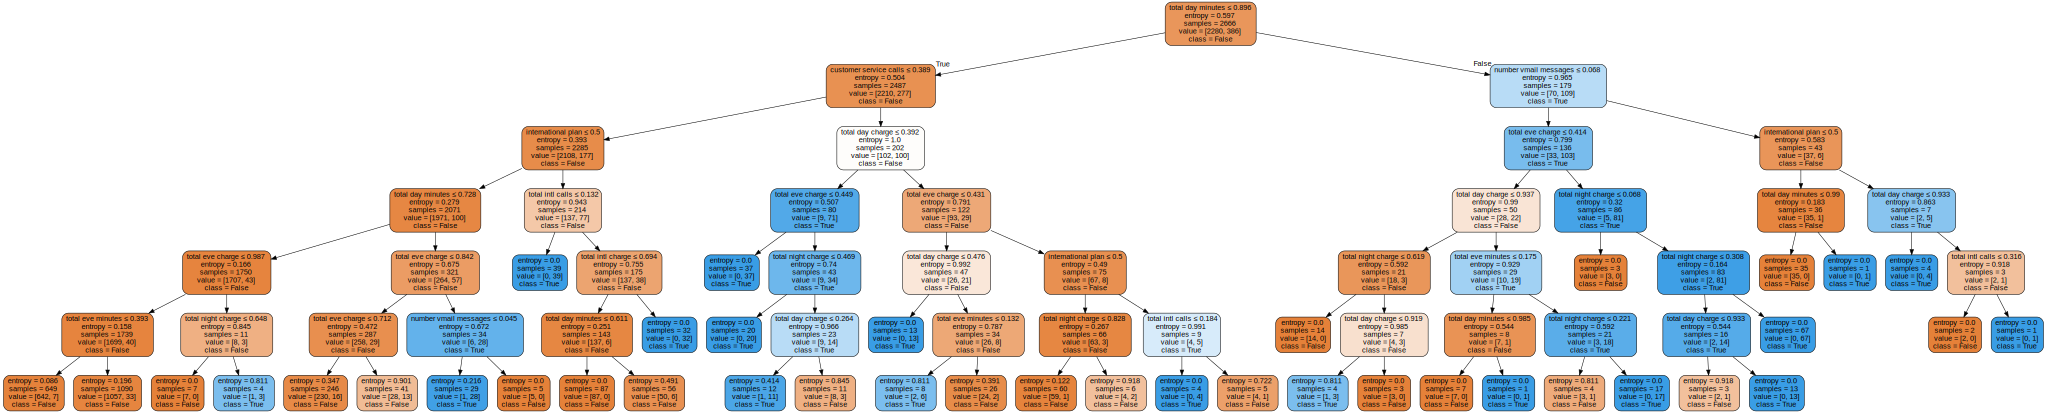

In [126]:
dot_data = tree.export_graphviz(dec_tree, out_file=None,
                               feature_names=X_train_2.columns,
                               class_names=y_test.unique().astype(str),
                               filled=True, rounded=True,
                               special_characters=True
                               )
graph = graphviz.Source(dot_data)
graph

#### Feature Importance

In [127]:
### Calculating feature importance again-

for i, column in enumerate(X_train_2):
    print('Importance of feature {}:, {:.3f}'
          .format(column, dec_tree.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': 
                       [dec_tree.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

Importance of feature international plan:, 0.128
Importance of feature number vmail messages:, 0.050
Importance of feature total day minutes:, 0.230
Importance of feature total day charge:, 0.105
Importance of feature total eve minutes:, 0.023
Importance of feature total eve charge:, 0.120
Importance of feature total night charge:, 0.049
Importance of feature total intl calls:, 0.070
Importance of feature total intl charge:, 0.087
Importance of feature customer service calls:, 0.139


##### We notice total day minutes seems more important now, along with intl plan and total eve mins.

#### CM and CR

In [128]:
print(confusion_matrix(y_test, dec_tree.predict(X_test_2)))
print(classification_report(y_test, dec_tree.predict(X_test_2)))

[[526  44]
 [ 21  76]]
              precision    recall  f1-score   support

       False       0.96      0.92      0.94       570
        True       0.63      0.78      0.70        97

    accuracy                           0.90       667
   macro avg       0.80      0.85      0.82       667
weighted avg       0.91      0.90      0.91       667



#### Random Forest

In [129]:
rf = RandomForestClassifier(random_state=101)

params = {
    'max_features': [1, 'sqrt', 'log2'],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'criterion': ['entropy', 'gini']
}

grid = GridSearchCV(estimator= rf, param_grid=params, verbose=1)

In [130]:
grid.fit(X_train_2, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=101),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 'sqrt', 'log2']},
             verbose=1)

In [131]:
rf_best = grid.best_estimator_

#### CM and CR

In [132]:
print(confusion_matrix(y_test, rf_best.predict(X_test_2)))
print(classification_report(y_test, rf_best.predict(X_test_2)))

[[526  44]
 [ 26  71]]
              precision    recall  f1-score   support

       False       0.95      0.92      0.94       570
        True       0.62      0.73      0.67        97

    accuracy                           0.90       667
   macro avg       0.79      0.83      0.80       667
weighted avg       0.90      0.90      0.90       667



##### Observations...Decision tree has 78% recall while random forest has 73%.

### Model 4

#### Refine Features

In [134]:
columns_to_drop = ['number vmail messages', 
                   'total night charge', 
                   'total eve minutes']

X_train_3 = X_train_2.drop(columns=columns_to_drop)
X_test_3 = X_test_2.drop(columns=columns_to_drop)


In [135]:
dec_tree = DecisionTreeClassifier(criterion='entropy', 
                                  max_depth=6, 
                                  random_state=1)
dec_tree.fit(X_train_3, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

#### Plot Decision Tree

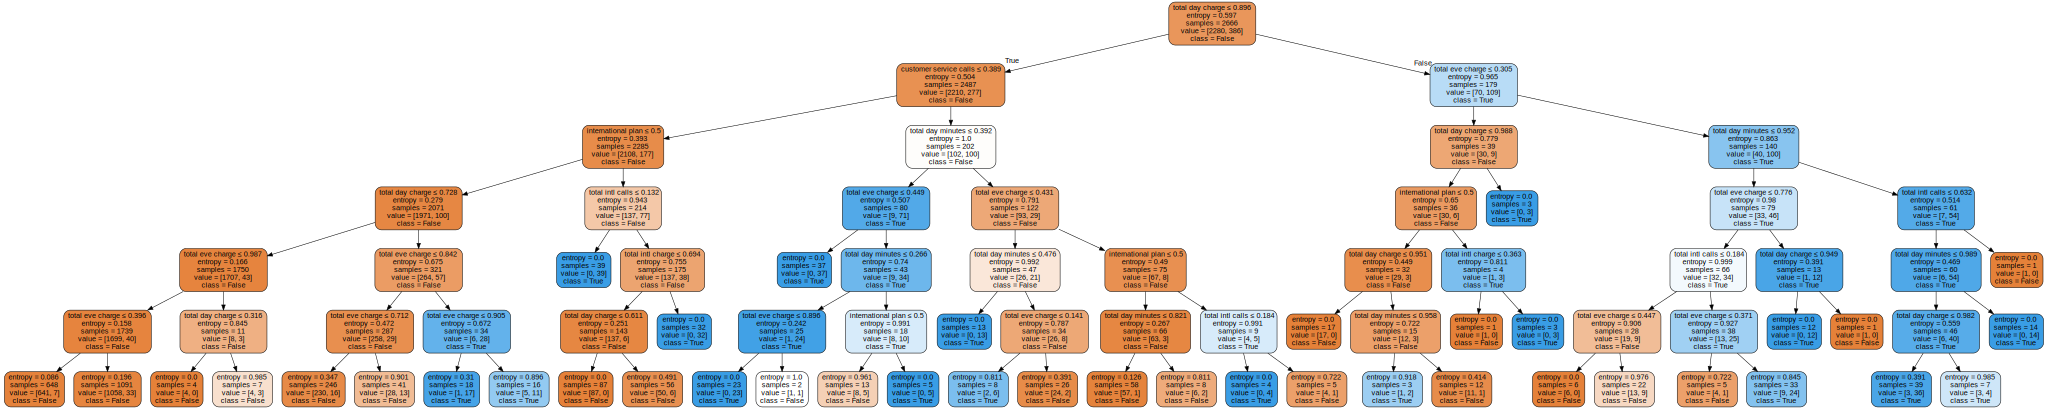

In [136]:
dot_data = tree.export_graphviz(dec_tree, out_file=None,
                               feature_names=X_train_3.columns,
                               class_names=y_test.unique().astype(str),
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Feature Importance

In [137]:
### Calculating feature importance again-

for i, column in enumerate(X_train_3):
    print('Importance of feature {}:, {:.3f}'
          .format(column, dec_tree.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': 
                       [dec_tree.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

Importance of feature international plan:, 0.138
Importance of feature total day minutes:, 0.113
Importance of feature total day charge:, 0.261
Importance of feature total eve charge:, 0.157
Importance of feature total intl calls:, 0.082
Importance of feature total intl charge:, 0.098
Importance of feature customer service calls:, 0.151


##### Total Day mins >>> Total Eve mins >>> International Plan

#### CM and CR

In [138]:
print(confusion_matrix(y_test, dec_tree.predict(X_test_3)))
print(classification_report(y_test, dec_tree.predict(X_test_3)))

[[515  55]
 [ 28  69]]
              precision    recall  f1-score   support

       False       0.95      0.90      0.93       570
        True       0.56      0.71      0.62        97

    accuracy                           0.88       667
   macro avg       0.75      0.81      0.77       667
weighted avg       0.89      0.88      0.88       667



#### Random Forest

In [139]:
rf = RandomForestClassifier(random_state=101)

params = {
    'max_features': [1, 'sqrt', 'log2'],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'criterion': ['entropy', 'gini']
}

grid = GridSearchCV(estimator= rf, param_grid=params, verbose=1)

In [140]:
grid.fit(X_train_3, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=101),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 'sqrt', 'log2']},
             verbose=1)

In [141]:
rf_best = grid.best_estimator_

#### CM and CR

In [142]:
print(confusion_matrix(y_test, rf_best.predict(X_test_3)))
print(classification_report(y_test, rf_best.predict(X_test_3)))

[[514  56]
 [ 29  68]]
              precision    recall  f1-score   support

       False       0.95      0.90      0.92       570
        True       0.55      0.70      0.62        97

    accuracy                           0.87       667
   macro avg       0.75      0.80      0.77       667
weighted avg       0.89      0.87      0.88       667



##### Observations...Decision tree has 71% recall while random forest has 70%.

### Model 5 (with SMOTE)

In [143]:
X = X_train  # features
y = y_train  # target vector
print('X shape:  {}'.format(np.shape(X)))
print('y shape:  {}'.format(np.shape(y)))

X shape:  (2666, 18)
y shape:  (2666,)


#### Plot 

In [144]:
smote = SMOTE(random_state=12)

X_train_smote, y_train_smote = smote.fit_resample(X, y)

print(f'X_train_smote shape:  {X_train_smote.shape}')
print(f'y_train_smote shape:  {y_train_smote.shape}')

X_train_smote shape:  (4560, 18)
y_train_smote shape:  (4560,)


#### Plot Decision Tree

In [145]:
dec_tree_smote = DecisionTreeClassifier(criterion='entropy', 
                                        max_depth=6, 
                                        random_state=1)
dec_tree_smote.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

#### Feature Importance

In [146]:
### Calculating feature importance again-

for i, column in enumerate(X_train_smote):
    print('Importance of feature {}:, {:.3f}'
          .format(column, dec_tree_smote.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': 
                       [dec_tree_smote.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

Importance of feature account length:, 0.002
Importance of feature international plan:, 0.170
Importance of feature voice mail plan:, 0.057
Importance of feature number vmail messages:, 0.013
Importance of feature total day minutes:, 0.011
Importance of feature total day calls:, 0.000
Importance of feature total day charge:, 0.261
Importance of feature total eve minutes:, 0.061
Importance of feature total eve calls:, 0.000
Importance of feature total eve charge:, 0.046
Importance of feature total night minutes:, 0.014
Importance of feature total night calls:, 0.004
Importance of feature total night charge:, 0.014
Importance of feature total intl minutes:, 0.012
Importance of feature total intl calls:, 0.039
Importance of feature total intl charge:, 0.048
Importance of feature customer service calls:, 0.248
Importance of feature Division:, 0.000


#### CM and CR

In [147]:
print(confusion_matrix(y_test, dec_tree_smote.predict(X_test)))
print(classification_report(y_test, dec_tree_smote.predict(X_test)))

[[470 100]
 [ 22  75]]
              precision    recall  f1-score   support

       False       0.96      0.82      0.89       570
        True       0.43      0.77      0.55        97

    accuracy                           0.82       667
   macro avg       0.69      0.80      0.72       667
weighted avg       0.88      0.82      0.84       667



#### Random Forest

In [148]:
rf_grid = GridSearchCV(estimator= RandomForestClassifier(),
                       param_grid=params, scoring='recall')

In [149]:
rf_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 'sqrt', 'log2']},
             scoring='recall')

In [150]:
rf_grid.best_params_

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt'}

#### CM and CR

In [151]:
print(confusion_matrix(y_test, rf_grid.predict(X_test)))
print(classification_report(y_test, rf_grid.predict(X_test)))

[[475  95]
 [ 24  73]]
              precision    recall  f1-score   support

       False       0.95      0.83      0.89       570
        True       0.43      0.75      0.55        97

    accuracy                           0.82       667
   macro avg       0.69      0.79      0.72       667
weighted avg       0.88      0.82      0.84       667



##### Observations...Decision tree has 77% recall while random forest has 75%.

#### Plotting Feature Importance

In [152]:
rf_grid.best_estimator_.feature_importances_

array([0.03379856, 0.07555959, 0.02266181, 0.02514372, 0.10900664,
       0.03448624, 0.11355423, 0.0589571 , 0.02862334, 0.05408608,
       0.03965062, 0.02768606, 0.03947538, 0.03654589, 0.07108747,
       0.03425193, 0.17370141, 0.02172392])

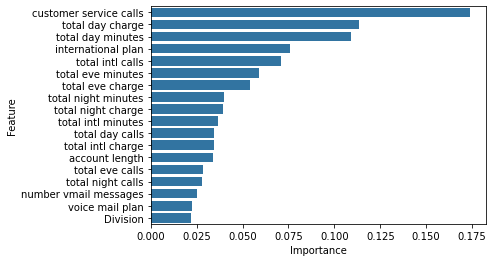

In [153]:
FI_df = pd.DataFrame(
    list(zip(X_train_smote.columns, 
             rf_grid.best_estimator_.feature_importances_)),
    columns=['Feature', 'Importance']
)

FI_df.sort_values('Importance', inplace=True, ascending=False)


sns.barplot(x = 'Importance', y = 'Feature', data = FI_df, color = 'tab:blue')

### Model 6 (SMOTE w/ Best Model Features)

##### Using SMOTE (Synthetic Minority Oversampling Technique) with best model to help class imbalance

In [159]:
### USE MODEL 2 FEATURE SELECTION...best model so far.

In [160]:
X = X_train_1  # features
y = y_train  # target vector
print('X shape:  {}'.format(np.shape(X)))
print('y shape:  {}'.format(np.shape(y)))

X shape:  (2666, 14)
y shape:  (2666,)


In [161]:
smote = SMOTE(random_state=12)

X_train_smote, y_train_smote = smote.fit_resample(X, y)

print(f'X_train_smote shape:  {X_train_smote.shape}')
print(f'y_train_smote shape:  {y_train_smote.shape}')

X_train_smote shape:  (4560, 14)
y_train_smote shape:  (4560,)


#### Plot Decision Tree

In [162]:
dec_tree_smote = DecisionTreeClassifier(criterion='entropy', 
                                        max_depth=6, 
                                        random_state=1)
dec_tree_smote.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

#### Feature Importance

In [163]:
### Calculating feature importance again-

for i, column in enumerate(X_train_smote):
    print('Importance of feature {}:, {:.3f}'
          .format(column, dec_tree_smote.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column],
                       'Feature Importance Score': 
                       [dec_tree_smote.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

Importance of feature international plan:, 0.168
Importance of feature number vmail messages:, 0.061
Importance of feature total day minutes:, 0.167
Importance of feature total day charge:, 0.118
Importance of feature total eve minutes:, 0.017
Importance of feature total eve calls:, 0.000
Importance of feature total eve charge:, 0.097
Importance of feature total night minutes:, 0.015
Importance of feature total night calls:, 0.004
Importance of feature total night charge:, 0.007
Importance of feature total intl calls:, 0.042
Importance of feature total intl charge:, 0.054
Importance of feature customer service calls:, 0.247
Importance of feature Division:, 0.002


#### CM and CR

In [165]:
print(confusion_matrix(y_test, dec_tree_smote.predict(X_test_1)))
print(classification_report(y_test, dec_tree_smote.predict(X_test_1)))

[[455 115]
 [ 21  76]]
              precision    recall  f1-score   support

       False       0.96      0.80      0.87       570
        True       0.40      0.78      0.53        97

    accuracy                           0.80       667
   macro avg       0.68      0.79      0.70       667
weighted avg       0.87      0.80      0.82       667



#### Random Forest

In [166]:
rf_grid = GridSearchCV(estimator= RandomForestClassifier(), 
                       param_grid=params, scoring='recall')

In [167]:
rf_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 'sqrt', 'log2']},
             scoring='recall')

In [168]:
rf_grid.best_params_

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt'}

#### CM and CR

In [169]:
print(confusion_matrix(y_test, rf_grid.predict(X_test_1)))
print(classification_report(y_test, rf_grid.predict(X_test_1)))

[[479  91]
 [ 23  74]]
              precision    recall  f1-score   support

       False       0.95      0.84      0.89       570
        True       0.45      0.76      0.56        97

    accuracy                           0.83       667
   macro avg       0.70      0.80      0.73       667
weighted avg       0.88      0.83      0.85       667



##### Observations...Decision tree has 78%....while random forest has 76% recall.

#### Final Feature Importance

In [170]:
rf_grid.best_estimator_.feature_importances_

array([0.09444449, 0.04553556, 0.13540737, 0.1260381 , 0.05609924,
       0.03026346, 0.06275296, 0.04216946, 0.03104091, 0.03720454,
       0.06881386, 0.04896497, 0.19856912, 0.02269595])

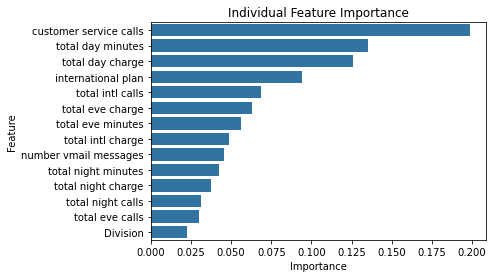

In [171]:
FI_df = pd.DataFrame(
    list(zip(X_train_smote.columns, 
             rf_grid.best_estimator_.feature_importances_)),
    columns=['Feature', 'Importance']
)

FI_df.sort_values('Importance', inplace=True, ascending=False)


sns.barplot(x = 'Importance', y = 'Feature', data = FI_df, color = 'tab:blue').set_title('Individual Feature Importance')
plt.savefig('Final Feature Importance')

# Interpret

##### The Biggest Takeaways

**Conclusion-**

The most important factors to look at when determining if a client is likely to churn are total day mins/charge and total eve mins/charge which intuitively go hand in hand.  The pay structure for the offered telecommunications plans are linear, so the more people use the product, the more they are directly spending since they are paying per minute.  Customers who use a high amount of minutes are more than likely switching to another provider who can offer unlimited after a certain amount.  As the number of customer service calls increase, we see a drastic upturn in the number of churns.  This means that either the product itself needs to be improved so that less calls are being made to the service center, or that proper guidance for customer issues isn't being given and possibly we need to look into improving the helpfulness of our service employees by monitoring calls and seeing where improvements can be made.


**Recommendations-**

We recommend offering tiered plans for number of minutes used, and more importantly an unlimited minutes plan that will allow some users to experience a "Deal" while the others would end up paying a bit more.  Within the tiered plan, there can be penalties for going over that would entice those who generally would be beneath a certain threshold, to sign up for a bigger plan than needed.  

Another recommendation would be to monitor the customer service calls to provide insights as to why there are multiple calls being made from the same customers.  If it's for the same reasons across the board, we recommend improving the service in said capacity.  However, if it seems that customer service is failing to provide adequate guidance for certain things that the service cannot be improved on, we need to educate our employees on how to best help customers who are struggling to use the product.  

Both of these recommendations will allow customers to stay with the company longer, and generate more revenue from those who are currently using the product as well by "marketing" the tiered plans as discounts when for the most part they will allow the company to capture more profit.


**Future Work-**


In the future we want to investigate why international plan has a big percentage of customers within the feature that churn.  There isn't a huge portion of customers that have an international plan, so it isn't as much a need currently but if those who sign up for the service only want the international plan a deal might be offered to them to entice them to join on for our regular services as well.  This may be unpreventable though, seeing as though many of those people who have the international plan may be moving countries or going on vacation and only need that select service for a limited amount of time.